In [1]:
%load_ext autoreload
%autoreload 2

from math import ceil

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from plot_shift.profit_based_thresholds_plot import calculate_binary_classifier_curve, plot_profit_thresholds, calculate_profit_thresholds

In [2]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
# Split the dataset into training and testing sets
X, y = mnist.data, mnist.target.astype(int)

In [4]:
# Convert the target variable to binary (0 or 1) for the digit '5'
y_binary = (y == 5).astype(int)

In [5]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
random_state = 42

k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
models = [
    ["Logistic Regression", LogisticRegression(random_state=random_state)],
    ["Random Forest Classifier", RandomForestClassifier(random_state=random_state)],
]
model_scores = []

for name, model in models:
    # Initialize an array to hold the scores for each fold
    scores = np.zeros(len(y))

    for train_index, test_index in k_fold.split(X_scaled, y_binary):
        # Split the data into training and testing sets
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train = y_binary[train_index]
        # Fit the model and predict probabilities
        model.fit(X_train, y_train)
        scores[test_index] = model.predict_proba(X_test)[:, 1]

    # Collect model name and scores
    model_scores.append((name, scores))

Logistic Regression
Optimal Threshold: 0.1290
Maximum Profit: 56047
Precision: 0.6806
Recall: 0.9235
Calibrated Optimal Threshold: 0.1000
Calibrated Total Profit: 55789

Random Forest Classifier
Optimal Threshold: 0.2200
Maximum Profit: 61234
Precision: 0.8892
Recall: 0.9802
Calibrated Optimal Threshold: 0.1000
Calibrated Total Profit: 59198



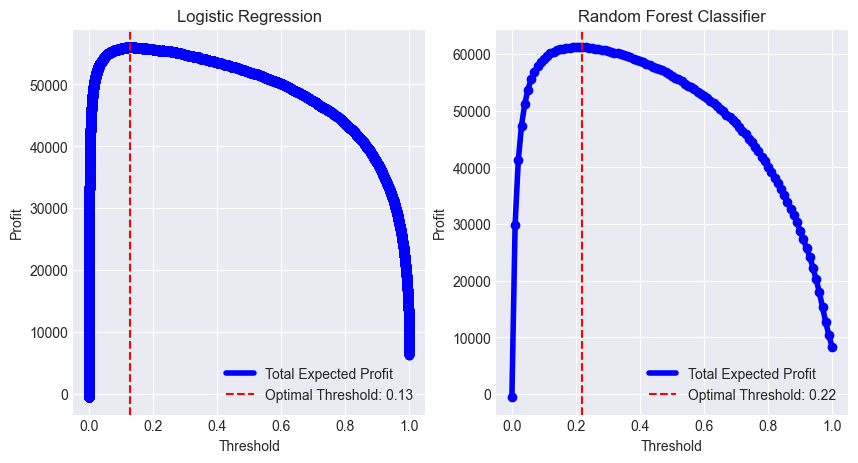

In [7]:
plt.style.use("seaborn-v0_8-darkgrid")

rows = ceil(len(model_scores) / 2)
_, axes = plt.subplots(rows, 2, figsize=(10, rows * 5))

for ax, (name, scores) in zip(axes.flatten(), model_scores):
    tps, fps, fns, tns, thresholds = calculate_binary_classifier_curve(y_binary, scores)
    (
        total_profits,
        maximum_profit,
        optimal_threshold,
        precision,
        recall,
        calibrated_optimal_threshold,
        calibrated_total_profit,
    ) = calculate_profit_thresholds(
        tps,
        fps,
        fns,
        tns,
        thresholds,
    )
    plot_profit_thresholds(
        total_profits,
        thresholds,
        optimal_threshold,
        ax=ax,
        model_name=name,
    )

    print(name)
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Maximum Profit: {maximum_profit}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Calibrated Optimal Threshold: {calibrated_optimal_threshold:.4f}")
    print(f"Calibrated Total Profit: {calibrated_total_profit}")
    print()
    